# NBA Tournament


## Table of Contents

- Introduction
- Data: Collection, Cleaning and Preprocessing
- Machine Learning
- NBA Tournament
- Conclusion


### Introduction

This project stems from a [ proposed project ] developed for a Machine Learning course, using Supervised Learning. I will attempt to gain better results and try out different models to establish a well defined tournament.
Previously, I used features intented to aid in winning a game such as Block, Steal, Rebound, etc. Logistic and linear regression were the only models used to make these winning prediction. <br/>
For this project, I will add more features and experiment with more regression models while using a more and advanced data to create an efficient model to predict the winner of team match ups, using data extracted from [NBA Site](https://www.nba.com)

<font color=red>Note:</font> [Selenium](https://selenium-python.readthedocs.io/installation.html) was used to retreive the source data. <br/>
This notebook contains interactive graphs which may require you to install a few dependencies. Graph images are displayed below the respected cell to view without running the program.


### Data


#### Collection [Selenium]

Below is the Selenium code used to retreive the our listings
Here we are going to extract the basketball seasons from the [NBA Site](https://www.nba.com/stats/teams/boxscores-traditional)


In [1]:
# Importing all neccesary packages
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import ElementClickInterceptedException as ECIE, NoSuchElementException as NSEE, StaleElementReferenceException as SERE, TimeoutException as TE, ElementNotInteractableException as ENIE

from openpyxl import Workbook, load_workbook
from buckets import dimes
import time
import re

In [2]:
import pandas as pd
import numpy as np

##### Table Collection & Organization

In [3]:
# Webdriver: Chrome | Site: NBA site

driver = webdriver.Chrome()
# url = "https://www.nba.com/stats/teams/boxscores-traditional"
# driver.get(url)


In [ ]:
# Create an Excel to begin data transfer
wb = Workbook()
wb.save('nba_box_scores.xlsx')
ws = wb.active
dfs = []

In [ ]:
# Dictionary created from NBA Glossary
driver.execute_script("window.scrollTo(0,300)")

glossary_bttn = WebDriverWait(driver, 10).until(EC.element_to_be_clickable(driver.find_element(By.CLASS_NAME, "Crom_cromGlossary__ZHrZf")))
glossary_bttn.click() # View Glossary

abbr_list = {}

abbrs = driver.find_elements(By.CLASS_NAME, "StatsTableGlossary_dt__GPooh") # Abbr
defs = driver.find_elements(By.CLASS_NAME, "StatsTableGlossary_dd__zcr38") # defs

for idx, ab in enumerate(abbrs):
    abbr_list[ab.text] = defs[idx].text

glossary_bttn.click() # Close Glossary


In [ ]:
# Capture all seasons in the list from web page
season_drpdwn = Select(driver.find_element(By.CLASS_NAME,"DropDown_select__4pIg9"))
seasons_arr = [sn.text for sn in season_drpdwn.options]
xpath_table = dimes.get('XPATH_TABLE')

In [ ]:
# Ensure table is retrieved from 'Regular Season' Games
ssn_type_drpdwn = driver.find_element(By.XPATH,'//*[@id="__next"]/div[2]/div[2]/div[3]/section[1]/div/div/div[2]/label/div')
ssn_type = Select(driver.find_element(By.XPATH, '//*[@id="__next"]/div[2]/div[2]/div[3]/section[1]/div/div/div[2]/label/div/select'))
ssn_type.select_by_visible_text("Regular Season")


In [ ]:
# Extact, Manipulate and Insert Seasons' table into  Excel

def assign_names(matches, teams, sn, df):
        
    print(f'Made it in for Season: {sn} with shape {df.shape}')

    # print(len(matches), '\n', len(teams), '\n', sn, '\n', df.shape) 
    team_names = []
    opp_names = []
    opp_abbrs = []

    # Assign names to team and opponent Series respectfully
    for i,match in enumerate(matches):

        team_abbr = re.split((r'vs. | @'),match)[0].rstrip()
        opp_abbr = re.split((r'vs. | @'),match)[1].lstrip()

        if team_abbr in teams:
            team_names.append(teams[team_abbr])
        if opp_abbr in teams:
            opp_names.append(teams[opp_abbr])
            opp_abbrs.append(opp_abbr)    

    df.insert(1, 'TEAM', team_names)
    df.insert(2, 'OPP ABBR', opp_abbrs)
    df.insert(3, 'OPPONENT', opp_names)
    df.insert(4, "SEASON", sn)
    
    team_names.clear()
    opp_abbrs.clear()
    opp_names.clear()

    
    return df


In [ ]:
# Driver Code

xpath_pages = dimes.get('XPATH_PAGES')
teams = {}

for i, sn in enumerate(seasons_arr):


    try:

        ad = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()
        cookie = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[3]/div[2]/div/div[1]/div/div[2]/div/button'))).click()

        season_drpdwn = Select(driver.find_element(By.CLASS_NAME,"DropDown_select__4pIg9"))
        season_drpdwn.select_by_visible_text(sn)
        print(sn)

        page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
        time.sleep(2)

        pages = Select(driver.find_element(By.XPATH, xpath_pages))
        pages.select_by_visible_text("All")

    except:

        season_drpdwn = Select(driver.find_element(By.CLASS_NAME,"DropDown_select__4pIg9"))
        season_drpdwn.select_by_visible_text(sn)
        print(sn)

        page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
        time.sleep(2)

        pages = Select(driver.find_element(By.XPATH, xpath_pages))
        pages.select_by_visible_text("All")
        time.sleep(2)

    table = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, xpath_table))).get_attribute("outerHTML")
    sub_df = pd.read_html(table)[0]
    sub_df.dropna(how='all', axis=1, inplace=True)
    sub_df = sub_df.rename(columns={'TEAM': 'TEAM ABBR'})    
    all_teams = sub_df['TEAM ABBR'].unique()

    matches = sub_df['MATCH UP']
    
    print(f'Number of Teams this Season: {len(all_teams)}')
    # print(sub_df)

    if all(ele in teams for ele in all_teams): # Assign existing names to Abbreviations

        new_df = assign_names(matches, teams, sn, sub_df)
        dfs.append(new_df)

        # Append each Season's table into Excel file
        with pd.ExcelWriter(path='nba_box_scores.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            new_df.to_excel(writer, sheet_name= sn, index=False, header=True)
    
    else:
        # Get all names missing from the teams list
        # Handle all possible exceptions 
        
        missing_teams = [t for t in all_teams if t not in teams]
        print(missing_teams)
        for team in missing_teams:
        
            try:
                if team == 'ORL':
                    teams[team] = 'ORLANDO MAGIC'
                else:
                    linked_text = WebDriverWait(driver,2).until(EC.presence_of_element_located((By.LINK_TEXT, team)))
                    linked_text.click()
                    teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                    driver.execute_script("window.history.go(-1)") # go back a page
                    time.sleep(2)
                print(f'{team} Cleared!')
        

            except ECIE: # Overlay may be blocking focused elements
                print('Entered ECIE: Element Click Intercepted Exception')
                print(f'Nope!! Trying to capture {team} again')
                ad = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()
                cookie = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[3]/div[2]/div/div[1]/div/div[2]/div/button'))).click()


                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')

            except NSEE: # Element doesn't exist. 
                print('Entered NSSE: No Such Element Exception')
                time.sleep(1)
                ad = WebDriverWait(driver,20).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()

                page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
                time.sleep(1.5)

                pages = Select(driver.find_element(By.XPATH, xpath_pages))
                pages.select_by_visible_text("All")

                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')
            
            except TE: 
                print('Entered TE: Timeout Exception')
                ad = WebDriverWait(driver,20).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()

                print(f'Trying to capture {team} again')

                page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
                time.sleep(1.5)

                pages = Select(driver.find_element(By.XPATH, xpath_pages))
                pages.select_by_visible_text("All")

                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')
                continue

            except SERE:
                print('Entered SERE: Stale Element Reference Exception')

                page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
                time.sleep(2)

                pages = Select(driver.find_element(By.XPATH, xpath_pages))
                pages.select_by_visible_text("All")

                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')

            except ENIE:
                print('Entered ENIE: Element Not Interactable Exception')
                ad = WebDriverWait(driver,20).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()

                page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
                time.sleep(1.5)

                pages = Select(driver.find_element(By.XPATH, xpath_pages))
                pages.select_by_visible_text("All")

                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')

        new_df = assign_names(matches, teams, sn, sub_df)
        dfs.append(new_df)

        with pd.ExcelWriter(path='nba_box_scores.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            new_df.to_excel(writer, sheet_name= sn, index=False, header=True)
        


In [ ]:
# Combine all tables for DataFrame and Files
df = pd.concat([x for x in dfs], ignore_index=True)

with pd.ExcelWriter(path='nba_box_scores.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df.to_excel(writer, sheet_name= 'Sheet', index=False, header=True)
    df.to_csv('nba_box_scores.csv', index=False)

##### Using another url for more data features.

In [4]:
url2 = 'https://www.nba.com/stats/teams'
driver.get(url2)


In [23]:
# Get the NBA regions
group = []

region_list = driver.find_elements(By.CLASS_NAME, 'StatsTeamsList_division__ZUezr')

# Region: Atlantic, Central, Southeast, Northwest, Pacific, Southwest
for region in region_list:
    rgn = region.text.split('\n')
    group.append(rgn)

region_headers = [rh.pop(0) for rh in group]
group = np.array(group).T

df2 = pd.DataFrame(
    data = group,
    columns=region_headers
)

# Conference: E or W


In [ ]:
df2

In [4]:
url3 = 'https://www.nba.com/standings'
driver.get(url3)


In [90]:

confs = driver.find_elements(By.CLASS_NAME, 'Crom_base__f0niE')
division = driver.find_elements(By.CLASS_NAME, 'Crom_caption__Yv_rH')
conf_groups = []
c_names = []

dvsn = []


for conf in confs: # East | West Confs
    # c_names.clear()
    dvsn.append(re.split(r'\n',conf.text)[0])
    # print(re.split(r'\n',conf.text))
    lists = re.split(r'\n',conf.text)

    for idx,each in enumerate(lists):
        # print(each)
        if re.search(r'^\d{1,2}$',each) != None:
            # print(each)
            joint_tn = ''.join([lists[idx+1], lists[idx+2]])
            print(joint_tn)
            c_names.append(joint_tn)

    conf_groups.append(c_names)

    c_names = []

Boston Celtics
New York Knicks
Milwaukee Bucks
Cleveland Cavaliers
Orlando Magic
Indiana Pacers
Philadelphia 76ers
Miami Heat
Chicago Bulls
Atlanta Hawks
Brooklyn Nets
Toronto Raptors
Charlotte Hornets
Washington Wizards
Detroit Pistons
Oklahoma City Thunder
Denver Nuggets
Minnesota Timberwolves
LA Clippers
Dallas Mavericks
Phoenix Suns
New Orleans Pelicans
Los Angeles Lakers
Sacramento Kings
Golden State Warriors
Houston Rockets
Utah Jazz
Memphis Grizzlies
San Antonio Spurs
Portland Trail Blazers


In [91]:
conf_groups

[['Boston Celtics',
  'New York Knicks',
  'Milwaukee Bucks',
  'Cleveland Cavaliers',
  'Orlando Magic',
  'Indiana Pacers',
  'Philadelphia 76ers',
  'Miami Heat',
  'Chicago Bulls',
  'Atlanta Hawks',
  'Brooklyn Nets',
  'Toronto Raptors',
  'Charlotte Hornets',
  'Washington Wizards',
  'Detroit Pistons'],
 ['Oklahoma City Thunder',
  'Denver Nuggets',
  'Minnesota Timberwolves',
  'LA Clippers',
  'Dallas Mavericks',
  'Phoenix Suns',
  'New Orleans Pelicans',
  'Los Angeles Lakers',
  'Sacramento Kings',
  'Golden State Warriors',
  'Houston Rockets',
  'Utah Jazz',
  'Memphis Grizzlies',
  'San Antonio Spurs',
  'Portland Trail Blazers']]

In [87]:
conf_groups.clear()
c_names.clear()


In [ ]:
df3 = pd.DataFrame(
    data=conf_groups,
    columns= dvsn
)

In [ ]:

# Close all opened files and systems
wb.close()
driver.close()

#### Cleaning & Processing

Now we're going to:
- Read data from previously exported csv file
- Normalize the data to condense the distribution
- Update Team Abbreviations to its' lastest of today

In [119]:
# Read data
full_df = pd.read_csv('nba_box_scores.csv')

In [120]:
# Prepare name changes
old_abbrs = [['NOH','NOK'], 'VAN', 'CHH', 'SEA', 'NJN' ]
new_abbrs = ['NOP', 'MEM', 'CHA', 'OKC', 'BKN']

for idx,abbr in enumerate(old_abbrs):
    full_df = full_df.replace(abbr,new_abbrs[idx])

team_abbr = full_df['TEAM ABBR'].unique()
team_name = full_df['TEAM']
teams = {}

# Recreate teams Dictionary
for each in team_abbr:
    
    indicies = list(np.where(full_df['TEAM ABBR'] == each))[0]
    teams[each] = full_df['TEAM'].iloc[indicies[0]]    


##### Statistics Below


In [121]:
print(f"Size of Dataframe {full_df.shape}")


Size of Dataframe (66172, 28)


In [122]:
# Sorted Team List for easier read
from collections import OrderedDict

sorted_teamsDict = OrderedDict(sorted(teams.items()))

distinct_teams = sorted(full_df['TEAM'].unique())
wins = []
losses = []
total = []
win_rate = []

for each in sorted_teamsDict:

    win = sum(full_df[full_df['TEAM ABBR'] == each]['W/L'] == 'W')
    loss = sum(full_df[full_df['TEAM ABBR'] == each]['W/L'] == 'L')
    wins.append(win)
    losses.append(loss)
    total.append(win+loss)
    win_rate.append(round(win/(win+loss),2))

bar_chart_df = pd.DataFrame(data={'WINS':wins, 'LOSSES':losses, 'TOTAL': total, 'WIN RATE':win_rate}, index=sorted_teamsDict.values())

In [123]:
# Bar Chart of Results from SEASONS 1996-2024
bar_chart_df

,WINS,LOSSES,TOTAL,WIN RATE
ATLANTA HAWKS,1043,1180,2223,0.47
BROOKLYN NETS,994,1234,2228,0.45
BOSTON CELTICS,1212,1015,2227,0.54
CHARLOTTE HORNETS,902,1155,2057,0.44
CHICAGO BULLS,1067,1154,2221,0.48
CLEVELAND CAVALIERS,1079,1142,2221,0.49
DALLAS MAVERICKS,1256,975,2231,0.56
DENVER NUGGETS,1138,1091,2229,0.51
DETROIT PISTONS,1044,1178,2222,0.47
GOLDEN STATE WARRIORS,1091,1130,2221,0.49


In [124]:
# Bar Chart of Wins and Losses
from plotly import express as px

fig = px.bar(bar_chart_df, x= bar_chart_df.index, y= ['LOSSES','WINS'], barmode = 'stack', text_auto = True,
             height=400)

fig.update_layout(
    title= 'Wins & Losses of Teams [1996-2024]',
    xaxis_title='Team',
    yaxis_title='Total Games Played',
    legend_title='Result',
)
fig.show()



In [125]:
# Bar Chart of Overall Winning Rate
fig1 = px.bar(bar_chart_df, x= bar_chart_df.index, y='WIN RATE')

fig1.update_layout(
    title= 'Teams\' Historical Performance',
    xaxis_title='Team',
    yaxis_title='Win Rate',
)
fig1.show()

In [126]:
# Condense the distribution [Normalzation]

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

encoder = LabelEncoder()
scalar = MinMaxScaler()

full_df["W/L"] = encoder.fit_transform(full_df["W/L"]) # WIN: 1 , LOSE: 0

num_cols = full_df.select_dtypes(include='number')

norm_df = pd.DataFrame(scalar.fit_transform(num_cols), columns = num_cols.columns)
norm_df = pd.concat([full_df.drop(columns=num_cols.columns),norm_df], axis=1)

norm_df = norm_df.sort_values(by=['SEASON']).reset_index(drop=True)

# Prepare data for ML
quant_features = norm_df.select_dtypes(['category', 'object'])
qual_features =  norm_df.select_dtypes(['number'])

X = qual_features.drop(columns=['W/L'])
y = qual_features['W/L']

#### Machine Learning

- Splitting data as 80/10/10 train-val-test
- Experiementing DecisionTreeRegressor

In [129]:
# Decision Tree Regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as DTR


regression = DTR(criterion='absolute_error', max_depth= 15)

X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.2, random_state=42)

regression.fit(X_train,y_train)
y_pred = regression.predict(X_remain)

X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.2, random_state=42) # 0.25

regression.fit(X_val,y_val)
y_pred1 = regression.predict(X_test)

print('Train: ', round(regression.score(X_train,y_train), 2))
print('Val: ', round(regression.score(X_val,y_val), 2))
print('Test: ', round(regression.score(X_test,y_test), 2))


Train:  1.0
Val:  1.0
Test:  1.0


1.0
Mean Squared Error of testing set:0.0
              precision    recall  f1-score   support

        loss       1.00      1.00      1.00      1316
         win       1.00      1.00      1.00      1331

    accuracy                           1.00      2647
   macro avg       1.00      1.00      1.00      2647
weighted avg       1.00      1.00      1.00      2647



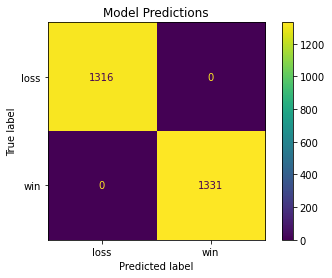

In [131]:
from sklearn.metrics import mean_squared_error, classification_report, ConfusionMatrixDisplay, accuracy_score
mse = mean_squared_error(y_remain,y_pred) # Gets the average loss between actual and predicted value of the target

print(accuracy_score(y_test,y_pred1))
print(f"Mean Squared Error of testing set:{round(mse,2)}")

print(classification_report(y_test,y_pred1,target_names=['loss','win'] )) # Explained in Markdown Note 3

cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred1 ,display_labels=['loss','win']) # Explained in Markdown Note 4
cm.ax_.set_title('Model Predictions')
print(cm)

# WORK ON REMAINDER
- Show Performance graphs
- Create Team Tournament [Regions & Conferences]
    - Probably add penalty (positive/negative) to the current match up

In [ ]:
# FO


winning_teams = norm_df[norm_df['WIN%'] >= win_rate1]

#This is the selected data
data_features = ['Team', 'Season', 'WIN%', 'W/L', 'FG%', '+/-', 'PTS',   'REB', 'STL', 'BLK']
selected_data = winning_teams[data_features]

# Sorting the data by season
selected_data = selected_data.sort_values('Season')
selected_data = selected_data.reset_index(drop=True)
# Predicting winners of matchups
predicted_winner_teamname = None
predicted_winner_season = None

# Iterate over pairs of teams
for i, team1 in selected_data.iterrows():
    for j, team2 in selected_data.iterrows():
        
        # Skip the same team matchups
        if i == j:
            continue

        # Concatenate features of both teams
        matchup_features = pd.concat([team1[['WIN%', 'FG%', 'PTS', 'REB', 'STL', 'BLK', '+/-']],
                                      team2[['WIN%', 'FG%', 'PTS', 'REB', 'STL', 'BLK', '+/-']]], axis=1)


        # Reshape the input for prediction
        matchup_features = matchup_features.transpose()
    


        # Predict the winner based on the results of the combined features
        winner_index = reg.predict(matchup_features)[0]


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:

        # Display the results
        if winner_index == 0:
            predicted_winner_teamname = team1['Team']
            predicted_winner_season = team1['Season']
        else:
            predicted_winner_teamname = team2['Team']
            predicted_winner_season = team2['Season']

        print("Matchup:")
        print("Team 1:", team1['Team'], "(", team1['Season'], ")")
        print("Team 2:", team2['Team'], "(", team2['Season'], ")")
        print("Predicted Winner:", predicted_winner_teamname, "(", predicted_winner_season, ")")
        print()


In [ ]:
# Create an empty dictionary
wins_count = {}
predicted_winners_info = {}

for i, team1 in selected_data.iterrows():
    for j, team2 in selected_data.iterrows():
        if i == j:
            continue

        matchup_features = pd.concat([team1[['WIN%', 'FG%', 'PTS', 'REB', 'STL', 'BLK', '+/-']],
                                      team2[['WIN%', 'FG%', 'PTS', 'REB', 'STL', 'BLK', '+/-']]], axis=1)

        matchup_features = matchup_features.transpose()

        winner_index = model.predict(matchup_features)[0]

        if winner_index == 0:
            predicted_winner_teamname = team1['Team']
            predicted_winner_season = team1['Season']
        else:
            predicted_winner_teamname = team2['Team']
            predicted_winner_season = team2['Season']

        # Store the name and season of the predicted winner
        predicted_winners_info[predicted_winner_teamname] = predicted_winner_season

        # Increment the number of wins for the predicted winner
        if predicted_winner_teamname in wins_count:
            wins_count[predicted_winner_teamname] += 1
        else:
            wins_count[predicted_winner_teamname] = 1

# Get the team with the most wins in the matchups
most_wins_winner = max(wins_count, key=wins_count.get)
most_wins_count = wins_count[most_wins_winner]

most_wins_winner_season = predicted_winners_info[most_wins_winner]

# Print the results
print("The team with the Most Wins:", most_wins_winner, "(", most_wins_winner_season, ")")
print("They won", most_wins_count, "games")